In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepsat-sat4/X_train_sat4.csv
/kaggle/input/deepsat-sat4/y_train_sat4.csv
/kaggle/input/deepsat-sat4/sat-4-full.mat
/kaggle/input/deepsat-sat4/y_test_sat4.csv
/kaggle/input/deepsat-sat4/X_test_sat4.csv
/kaggle/input/deepsat-sat4/sat4annotations.csv


# Welcome. This is an example of image classification using TensorFlow. We are using a satellite image dataset from Kaggle

In [3]:
# Because the image dataset is so large, the train dataset is too large to be loaded in on Kaggle. Therefore we are using the test dataset
# import the satellite data
X_train = pd.read_csv('/kaggle/input/deepsat-sat4/X_test_sat4.csv', header = None).values.reshape([100000,28,28,4])
Y_train = pd.read_csv('/kaggle/input/deepsat-sat4/y_test_sat4.csv', header = None)

# normalise the training data
X_train_norm = X_train/X_train.max()

In [4]:
# we want to visualise the data that we are dealing with. Before that we want to have a list of the classifications for each image so that we can plot it with our image

Y_name = Y_train.copy()

def convert_bool_df_to_value(df):
    
    df.loc[:,'Name'] = np.zeros(len(df))

    df.loc[:,'Name'][df[0] == 1] = 'Barren_Land'
    df.loc[:,'Name'][df[1] == 1] = 'Trees'
    df.loc[:,'Name'][df[2] == 1] = 'Grassland'
    df.loc[:,'Name'][df[3] == 1] = 'Other'


    return df['Name']

Y_name = convert_bool_df_to_value(Y_name)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


lets take a look at the first 100 images in the dataset (assuming the dataset is randomly shuffled)

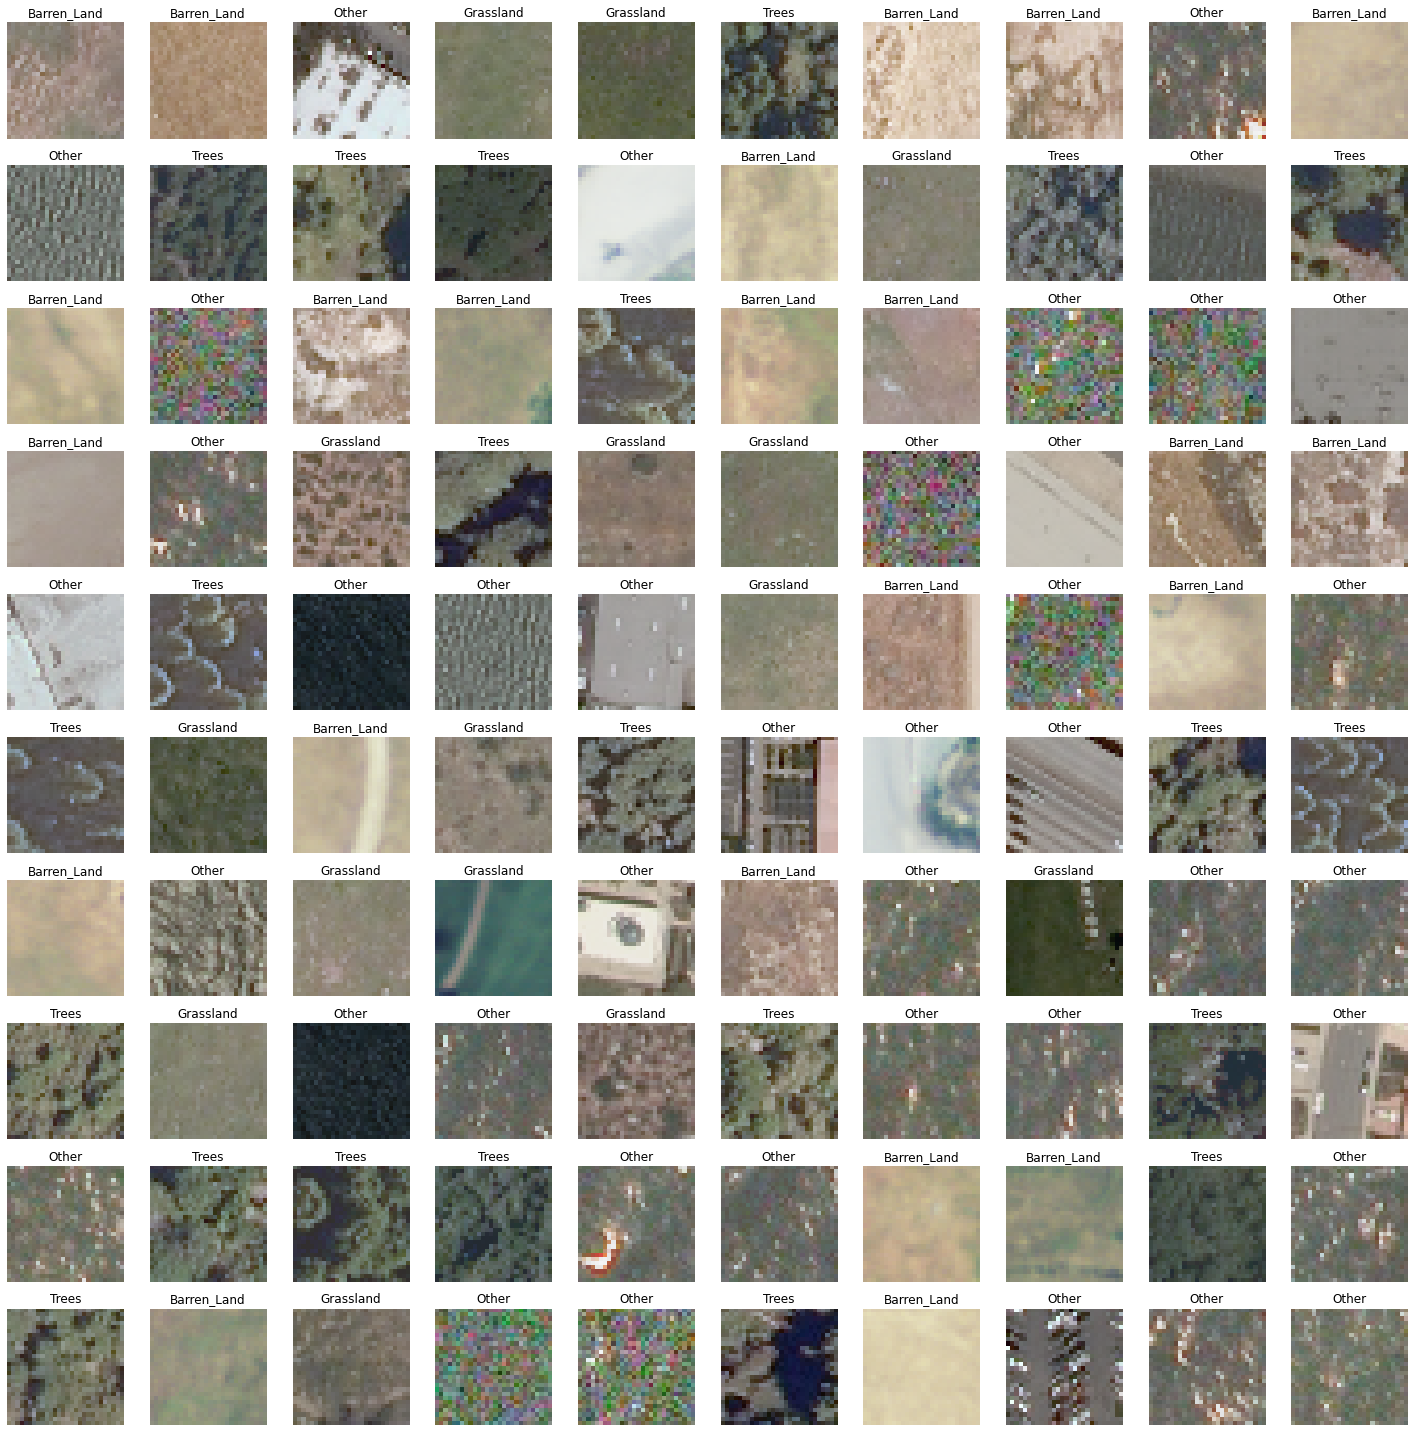

In [5]:
fig = plt.figure(figsize = (20,20))

for num, X, name in zip(np.arange(1,101), X_train, Y_name):
    ax = fig.add_subplot(10,10,num)
    ax.imshow(X[:,:,:3])
    ax.axis('off')
    ax.set_title(name)
plt.tight_layout()

We can see there are definitely grouping features. Trees are greenish and have round edges. Barren land is relatively homogeneous and dirt colored. Grassland is also relatively homogeneous but more greenish colored. We hope that our model is able to pick up on these features.

In [6]:
# Let's try to build a relivately simple model that has good accuracy

#%%time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()

# simple model consisting of 4 layers, focused on retrieving the most prominent features
model.add(layers.Conv2D(32, (3,3), activation="relu", input_shape = (28,28,4)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_norm,Y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.05)
model.summary()

Epoch 1/50
2969/2969 [==============================] - 31s 10ms/step - loss: 0.3019 - accuracy: 0.8951 - val_loss: 0.1745 - val_accuracy: 0.9384
Epoch 2/50
2969/2969 [==============================] - 30s 10ms/step - loss: 0.1686 - accuracy: 0.9450 - val_loss: 0.1771 - val_accuracy: 0.9412
Epoch 3/50
2969/2969 [==============================] - 30s 10ms/step - loss: 0.1424 - accuracy: 0.9528 - val_loss: 0.1477 - val_accuracy: 0.9458
Epoch 4/50
2969/2969 [==============================] - 32s 11ms/step - loss: 0.1234 - accuracy: 0.9591 - val_loss: 0.1761 - val_accuracy: 0.9382
Epoch 5/50
2969/2969 [==============================] - 30s 10ms/step - loss: 0.1123 - accuracy: 0.9634 - val_loss: 0.0825 - val_accuracy: 0.9728
Epoch 6/50
2969/2969 [==============================] - 30s 10ms/step - loss: 0.1050 - accuracy: 0.9645 - val_loss: 0.0968 - val_accuracy: 0.9660
Epoch 7/50
2969/2969 [==============================] - 30s 10ms/step - loss: 0.0972 - accuracy: 0.9666 - val_loss: 0.0846 -

Looks like our model has 98% accuracy after 50 epochs (15 min). Not bad for a simple model.

lets make a plot of some of our falsily classified data to see what it looks like

In [7]:
Y_pred = model.predict(X_train_norm)

In [8]:
Y_pred_name = Y_pred.copy()

# set highest probability to 1 and rest to 0
Y_pred_name[range(len(Y_pred_name)),
                   Y_pred_name.argmax(axis = 1)] = 1
Y_pred_name[Y_pred_name != 1.] = 0

# convert bool variable to actual name
Y_pred_name = convert_bool_df_to_value(pd.DataFrame(Y_pred_name))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [9]:
Y_false = Y_pred_name[Y_pred_name != Y_name]
Y_true = Y_pred_name[Y_pred_name == Y_name]
X_false = X_train[Y_pred_name != Y_name]

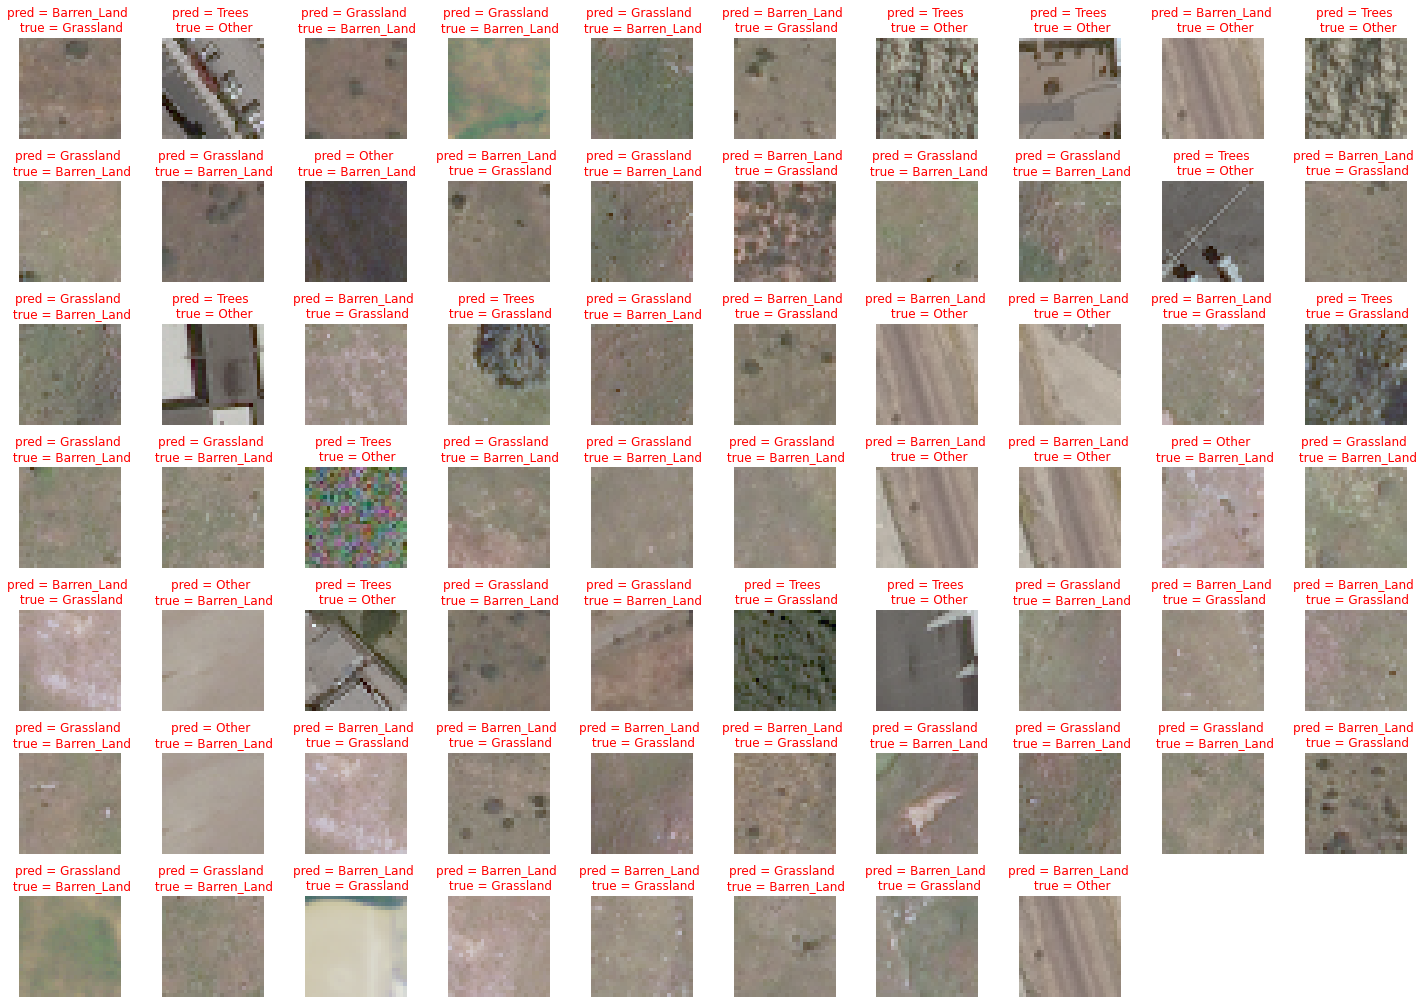

In [11]:
fig = plt.figure(figsize = (20,20))
k = 1

for X, Y_n, Y_p in zip(X_train[:10000], Y_name[:10000], Y_pred_name[:10000]):
    if Y_n != Y_p:
        ax = fig.add_subplot(10,10,k)
        ax.imshow(X[:,:,:3])
        ax.axis('off')
        ax.set_title('pred = {} \n true = {}'.format(Y_p, Y_n), color = 'red')
        k += 1
    else:
        continue
plt.tight_layout()

Our model still makes some mistakes. It seems biased towards predicting trees whenever there are sharp edges or shadows. Or whenever the distinction between grassland and barren land is not clear. But overall it does quite well with almost 99% accuracy.